In [1521]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pycountry_convert as pc
import re
from sklearn.metrics import r2_score, mean_squared_error
pd.options.mode.chained_assignment = None  # default='warn'


In [1522]:
transfers = pd.read_csv('data/transfers/all_transfers.csv')
all_players = pd.read_csv('data/players/all_players.csv')
recent_transfers = transfers[transfers['season'] >= 2017]
detailed_transfers = pd.merge(recent_transfers, all_players[[
                              'playerLink', 'currAge', 'height', 'foot']], on="playerLink", how="left")

detailed_transfers


playerName                               playerLink  playerAge  \
0         Ethan Ampadu      /ethan-ampadu/profil/spieler/392771         16   
1     Davinson Sánchez  /davinson-sanchez/profil/spieler/341429         21   
2           Juan Foyth        /juan-foyth/profil/spieler/480763         19   
3          Kyle Walker        /kyle-walker/profil/spieler/95424         27   
4              Ederson           /ederson/profil/spieler/238223         23   
...                ...                                      ...        ...   
3986   Ibrahim Cissoko   /ibrahim-cissoko/profil/spieler/575693         20   
3987      Mahdi Camara      /mahdi-camara/profil/spieler/324795         25   
3988   Mostafa Mohamed   /mostafa-mohamed/profil/spieler/462348         25   
3989       Andy Delort       /andy-delort/profil/spieler/122797         31   
3990   Boubacar Traoré   /boubacar-traore/profil/spieler/649020         21   

     playerPos playerCountry  playerMarketValue  transferFee  \
0           CB         Wales            9000000      2800000   
1           CB      Colombia           15000000     42000000   
2           RB     Argentina           25000000     10500000   
3           RB       England           13000000     52700000   
4           GK        Brazil           40000000     40000000   
...        ...           ...                ...          ...   
3986        LW   Netherlands            2500000      3000000   
3987        CM        France            3000000      3000000   
3988        CF         Egypt            6000000      5750000   
3989        CF       Algeria            7000000      5000000   
3990        DM          Mali            5000000     11000000   

                          clubLeft  \
0                      Exeter City   
1                   Ajax Amsterdam   
2     Club Estudiantes de La Plata   
3                Tottenham Hotspur   
4                       SL Benfica   
...                            ...   
3986                  NEC Nijmegen   
3987              AS Saint-Étienne   
3988                   Galatasaray   
3989                      OGC Nice   
3990                       FC Metz   

                                            clubLeftUrl  \
0                   /exeter-city/startseite/verein/6699   
1                 /ajax-amsterdam/startseite/verein/610   
2     /club-estudiantes-de-la-plata/startseite/verei...   
3              /tottenham-hotspur/startseite/verein/148   
4               /benfica-lissabon/startseite/verein/294   
...                                                 ...   
3986                /nec-nijmegen/startseite/verein/467   
3987            /as-saint-etienne/startseite/verein/618   
3988        /galatasaray-istanbul/startseite/verein/141   
3989                   /ogc-nizza/startseite/verein/417   
3990                     /fc-metz/startseite/verein/347   

                   clubJoined                                   clubJoinedUrl  \
0                  Chelsea FC               /fc-chelsea/startseite/verein/631   
1           Tottenham Hotspur        /tottenham-hotspur/startseite/verein/148   
2           Tottenham Hotspur        /tottenham-hotspur/startseite/verein/148   
3             Manchester City          /manchester-city/startseite/verein/281   
4             Manchester City          /manchester-city/startseite/verein/281   
...                       ...                                             ...   
3986              FC Toulouse              /fc-toulouse/startseite/verein/415   
3987        Stade Brestois 29          /stade-brest-29/startseite/verein/3911   
3988                FC Nantes                /fc-nantes/startseite/verein/995   
3989                FC Nantes                /fc-nantes/startseite/verein/995   
3990  Wolverhampton Wanderers  /wolverhampton-wanderers/startseite/verein/543   

     teamTransferType  season  valuation  currAge  height   foot  
0                  in    2017    6200000     22.0    1.82  right  
1                  in    2017  -2

In [1523]:
def getContinent(country_name):
    try:
        country_alpha2 = pc.country_name_to_country_alpha2(country_name)
        continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        continent_name = pc.convert_continent_code_to_continent_name(
            continent_code)
        return continent_name
    # adding manual continents for some countries
    except KeyError:
        if country_name in ['Wales', 'England', 'Scotland', 'Bosnia-Herzegovina', 'Northern Ireland', 'Kosovo']:
            return 'Europe'
        elif country_name in ["Cote d'Ivoire", 'The Gambia', 'Curacao', 'DR Congo']:
            return 'Africa'
        elif country_name in ['Korea, South', 'Korea, North']:
            return 'Asia'
        elif country_name in ['Neukaledonien']:
            return 'Oceania'
        else:
            return None


# Mapear países para continentes usando pycountry_convert
country_continent_mapping = {}

countries = detailed_transfers['playerCountry'].unique()

for country in countries:
    country_continent_mapping[country] = getContinent(country)

pos_mapping = {
    'RM': 'RW',
    'LM': 'LW',
    'SS': 'AM'
}


In [1524]:
detailed_transfers_mod = generalPreProcess(detailed_transfers)


In [1525]:
detailed_transfers_mod

playerPos  transferFee  season  playerAge_1  playerAge_2  playerPos_AM  \
0           CB      2800000    2017         16.0        256.0             0   
1           CB     42000000    2017         21.0        441.0             0   
2           RB     10500000    2017         19.0        361.0             0   
3           RB     52700000    2017         27.0        729.0             0   
4           GK     40000000    2017         23.0        529.0             0   
...        ...          ...     ...          ...          ...           ...   
3985        RB      1300000    2023         28.0        784.0             0   
3987        CM      3000000    2023         25.0        625.0             0   
3988        CF      5750000    2023         25.0        625.0             0   
3989        CF      5000000    2023         31.0        961.0             0   
3990        DM     11000000    2023         21.0        441.0             0   

      playerPos_CB  playerPos_CF  playerPos_CM  playerPos_DM  ...  \
0                1             0             0             0  ...   
1                1             0             0             0  ...   
2                0             0             0             0  ...   
3                0             0             0             0  ...   
4                0             0             0             0  ...   
...            ...           ...           ...           ...  ...   
3985             0             0             0             0  ...   
3987             0             0             1             0  ...   
3988             0             1             0             0  ...   
3989             0             1             0             0  ...   
3990             0             0             0             1  ...   

      playerPos_RW  continent_Africa  continent_Asia  continent_Europe  \
0                0                 0               0                 1   
1                0                 0               0                 0   
2                0                 0               0                 0   
3                0                 0               0                 1   
4                0                 0               0                 0   
...            ...               ...             ...               ...   
3985             0                 1               0                 0   
3987             0                 0               0                 1   
3988             0                 1               0                 0   
3989             0                 1               0                 0   
3990             0                 1               0                 0   

      continent_North America  continent_Oceania  continent_South America  \
0                           0                  0                        0   
1                           0                  0                        1   
2                           0                  0                        1   
3                           0                  0                        0   
4                           0                  0                        1   
...                       ...                ...                      ...   
3985                        0                  0                        0   
3987                        0                  0                        0   
3988                        0                  0                        0   
3989                        0                  0                        0   
3990                        0                  0                        0   

      height_1  height_2  ambidextrous  
0         1.82    3.3124             0  
1         1.87    3.4969             0  
2         1.87    3.4969             0  
3         1.83    3.3489             0  
4         1.88    3.5344             0  
...        ...       ...           ...  
3985      1.79    3.2041             0  
3987      1.78    3.1684             0  
3988      1.85    3.4225             0  
398

In [1526]:
def generalPreProcess(df):
    df = df.dropna(subset='height')
    # Transformação polinomial de grau 2 em 'playerAge'
    poly_features = PolynomialFeatures(degree=2, include_bias=False)
    playerAge_poly = poly_features.fit_transform(df[['playerAge']])
    df['playerAge_1'] = playerAge_poly[:, 0]
    df['playerAge_2'] = playerAge_poly[:, 1]

    # Remapeando algumas posições
    df['playerPos'] = df['playerPos'].replace(pos_mapping)

    # Transformar 'playerPos' em dummies
    playerPos_dummies = pd.get_dummies(df['playerPos'], prefix='playerPos')
    df = pd.concat([df, playerPos_dummies], axis=1)

    # Gerando dummies em continentes
    df['playerContinent'] = df['playerCountry'].map(country_continent_mapping)
    continent_dummies = pd.get_dummies(
        df['playerContinent'], prefix='continent')
    df = pd.concat([df, continent_dummies], axis=1)

    # Transformação polinomial de grau 2 em 'height'
    height_poly = poly_features.fit_transform(df[['height']])
    df['height_1'] = height_poly[:, 0]
    df['height_2'] = height_poly[:, 1]

    # Transformar 'foot' em uma dummie binária
    df['ambidextrous'] = (df['foot'] == 'both').astype(int)

    # Remover colunas originais que foram transformadas
    return df.drop(['playerName', 'clubJoined', 'clubJoinedUrl', 'teamTransferType', 'valuation', 'playerLink', 'currAge', 'playerMarketValue', 'clubLeft', 'clubLeftUrl', 'playerAge', 'playerCountry', 'height', 'foot', 'playerContinent'], axis=1)


""" Você pode aplicar a transformação polinomial e, em seguida, a normalização em uma feature sequencialmente. Isso pode ser benéfico em certos casos, principalmente quando a relação entre a feature e a variável alvo é complexa e não linear.

A transformação polinomial expande a feature em termos polinomiais, capturando relações não lineares. Em seguida, a normalização coloca os valores da feature em uma escala comum, evitando que uma feature com uma escala muito diferente domine a regressão linear.

Ao aplicar a normalização após a transformação polinomial, você garante que os valores polinomiais também estejam na mesma escala. Isso pode ajudar a estabilizar a regressão linear e melhorar a interpretação dos coeficientes. """


def normalizeCol(col):
    min_val = col.min()
    max_val = col.max()
    return (col-min_val) / (max_val - min_val)


In [1527]:
stats_types = ["standard", "shooting", "passing", "passing_types",
               "goal_shot_creation", "defense", "possession", "misc"]


In [1528]:
def_list = ['CB', 'RB', 'LB']
mid_list = ['CM', 'AM', 'DM', 'SS']
atk_list = ['RW', 'LW', 'RM', 'LM', 'CF']

all_pos_stats = {}
def_stats = {}
mid_stats = {}
atk_stats = {}

atk_dfs = []
mid_dfs = []
def_dfs = []
all_pos_dfs = []

for type in stats_types:
    df = generalPreProcess(pd.read_csv(
        f'data/transfers_stats/new/all/{type}.csv'))
    df = df[df['playerPos'] != 'GK']
    df = df.drop(['nextSeason', 'born'], axis=1)
    all_pos_stats[type] = df
    def_stats[type] = df[df['playerPos'].isin(def_list)]
    mid_stats[type] = df[df['playerPos'].isin(mid_list)]
    atk_stats[type] = df[df['playerPos'].isin(atk_list)]
    atk_dfs.append(atk_stats[type])
    mid_dfs.append(mid_stats[type])
    def_dfs.append(def_stats[type])
    all_pos_dfs.append(all_pos_stats[type])

def concatAll(dfs):
    concatenated_df = pd.concat(dfs, axis=1)
    concatenated_df = concatenated_df.loc[:, ~concatenated_df.columns.duplicated()]
    return concatenated_df

atk_stats["all"] = concatAll(atk_dfs)
mid_stats["all"] = concatAll(mid_dfs)
def_stats["all"] = concatAll(def_dfs)
all_pos_stats["all"] = concatAll(all_pos_dfs)


In [1529]:
def removeExtraCols(df):
    common_cols = list(df.columns.intersection(detailed_transfers_mod.columns))
    common_cols.remove('transferFee')
    df = df.drop(common_cols, axis=1)
    columns_to_drop = ['pos', 'age', '90s', 'league', 'team', 'nation']
    existing_columns = list(set(columns_to_drop).intersection(df.columns))
    return df.drop(existing_columns, axis=1)


In [1530]:
def getBestCols(df):
    # Calcular a matriz de correlação
    correlation_matrix = df.corr()

    correlation_with_target = correlation_matrix['transferFee']
    correlation_sorted = correlation_with_target.abs().sort_values(ascending=False)
    # Defina um limiar para selecionar apenas as colunas com correlação acima de um determinado valor
    correlation_threshold = 0.15

    # Selecione as colunas com correlação acima do limiar
    best_columns = correlation_sorted[abs(
        correlation_sorted) > correlation_threshold].index.tolist()

    # Plotar um mapa de calor da matriz de correlação
    import seaborn as sns

    # Calcular a matriz de correlação
    correlation_matrix = df[best_columns].corr()

    sns.heatmap(correlation_matrix, annot=True)
    plt.show()


In [1531]:
def removedAutocorrelations(df):
    corr_matrix = df.corr()

    # Definir o limite de correlação
    correlation_threshold = 0.9

    # Identificar colunas com alta autocorrelação que não são a variável objetivo
    highly_correlated_cols = []
    target_col = 'transferFee'

    # Identificar colunas com alta correlação entre si
    highly_correlated_cols = []

    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > correlation_threshold:
                colname_i = corr_matrix.columns[i]
                colname_j = corr_matrix.columns[j]
                if colname_i != target_col and colname_j != target_col:
                    if (abs(corr_matrix['transferFee'][colname_i]) > abs(corr_matrix['transferFee'][colname_j])):
                        highly_correlated_cols.append(colname_j)
                    else:
                        highly_correlated_cols.append(colname_i)

    df = df.drop(highly_correlated_cols, axis=1)

    # Calcular a matriz de correlação
    correlation_matrix = df.corr()

    correlation_with_target = correlation_matrix['transferFee']
    correlation_sorted = correlation_with_target.abs().sort_values(ascending=False)
    # Defina um limiar para selecionar apenas as colunas com correlação acima de um determinado valor
    correlation_threshold = 0.15

    # Selecione as colunas com correlação acima do limiar
    best_columns = correlation_sorted[correlation_sorted >
                                      correlation_threshold].index.tolist()

    # Plotar um mapa de calor da matriz de correlação
    import seaborn as sns

    # Calcular a matriz de correlação
    correlation_matrix = df[best_columns].corr()

    sns.heatmap(correlation_matrix, annot=True)
    plt.show()
    return correlation_matrix


# Standard


## All positions


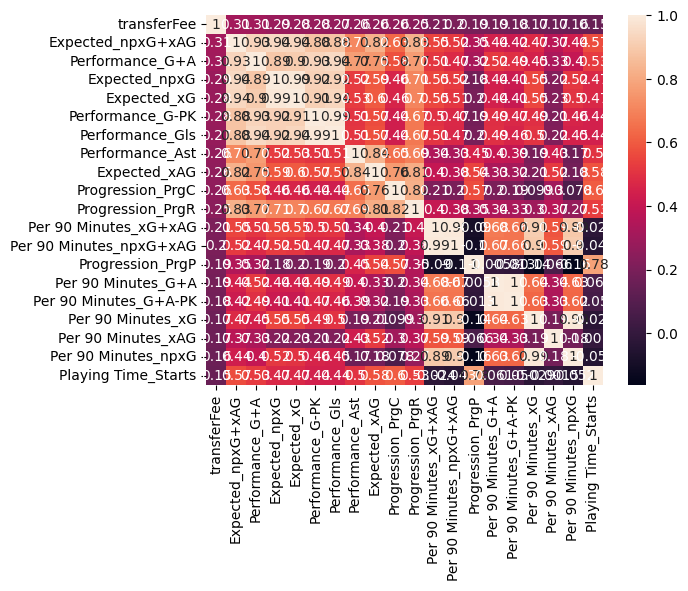

In [1532]:
df = all_pos_stats["standard"]
df = removeExtraCols(df)
getBestCols(df)


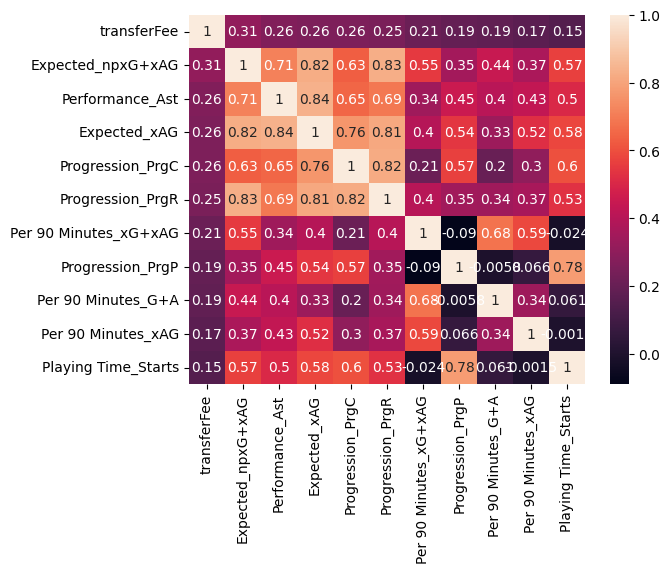

transferFee  Expected_npxG+xAG  Performance_Ast  \
transferFee               1.000000           0.307256         0.263530   
Expected_npxG+xAG         0.307256           1.000000         0.710602   
Performance_Ast           0.263530           0.710602         1.000000   
Expected_xAG              0.258773           0.824146         0.836598   
Progression_PrgC          0.257498           0.632762         0.648403   
Progression_PrgR          0.246560           0.826846         0.692933   
Per 90 Minutes_xG+xAG     0.209301           0.550133         0.344190   
Progression_PrgP          0.194783           0.350363         0.451494   
Per 90 Minutes_G+A        0.185849           0.444232         0.404924   
Per 90 Minutes_xAG        0.165816           0.370926         0.431961   
Playing Time_Starts       0.150088           0.567768         0.503168   

                       Expected_xAG  Progression_PrgC  Progression_PrgR  \
transferFee                0.258773          0.257498          0.246560   
Expected_npxG+xAG          0.824146          0.632762          0.826846   
Performance_Ast            0.836598          0.648403          0.692933   
Expected_xAG               1.000000          0.762437          0.809794   
Progression_PrgC           0.762437          1.000000          0.818580   
Progression_PrgR           0.809794          0.818580          1.000000   
Per 90 Minutes_xG+xAG      0.398145          0.211342          0.403574   
Progression_PrgP           0.543408          0.566497          0.348205   
Per 90 Minutes_G+A         0.331850          0.202404          0.342745   
Per 90 Minutes_xAG         0.521388          0.303226          0.365126   
Playing Time_Starts        0.579248          0.601137          0.529647   

                       Per 90 Minutes_xG+xAG  Progression_PrgP  \
transferFee                         0.209301          0.194783   
Expected_npxG+xAG                   0.550133          0.350363   
Performance_Ast                     0.344190          0.451494   
Expected_xAG                        0.398145          0.543408   
Progression_PrgC                    0.211342          0.566497   
Progression_PrgR                    0.403574          0.348205   
Per 90 Minutes_xG+xAG               1.000000         -0.089884   
Progression_PrgP                   -0.089884          1.000000   
Per 90 Minutes_G+A                  0.676782         -0.005784   
Per 90 Minutes_xAG                  0.586331          0.065945   
Playing Time_Starts                -0.024199          0.780620   

                       Per 90 Minutes_G+A  Per 90 Minutes_xAG  \
transferFee                      0.185849            0.165816   
Expected_npxG+xAG                0.444232            0.370926   
Performance_Ast                  0.404924            0.431961   
Expected_xAG                     0.331850            0.521388   
Progression_PrgC                 0.202404            0.303226   
Progression_PrgR                 0.342745            0.365126   
Per 90 Minutes_xG+xAG            0.676782            0.586331   
Progression_PrgP                -0.005784            0.065945   
Per 90 Minutes_G+A               1.000000            0.338326   
Per 90 Minutes_xAG               0.338326            1.000000   
Playing Time_Starts              0.060911           -0.001499   

                       Playing Time_Starts  
transferFee                       0.150088  
Expected_npxG+xAG                 0.567768  
Performance_Ast                   0.503168  
Expected_xAG                      0.579248  
Progression_PrgC                  0.601137  
Progression_PrgR                  0.529647  
Per 90 Minutes_xG+xAG            -0.024199  
Progression_PrgP                  0.780620  
Per 90 Minutes_G+A                0.060911  
Per 90 Minutes_xAG               -0.001499  
Playing Time_Starts               1.000000

In [1533]:
removedAutocorrelations(df)


## Attackers


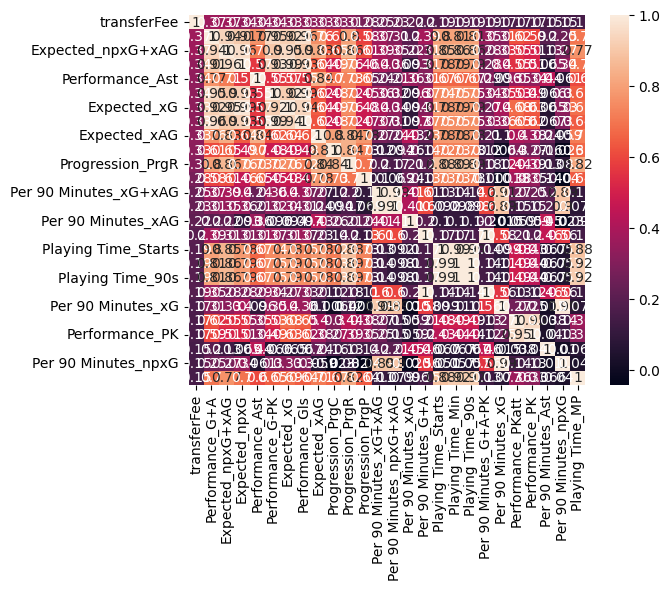

In [1534]:
df = atk_stats["standard"]
df = removeExtraCols(df)
getBestCols(df)


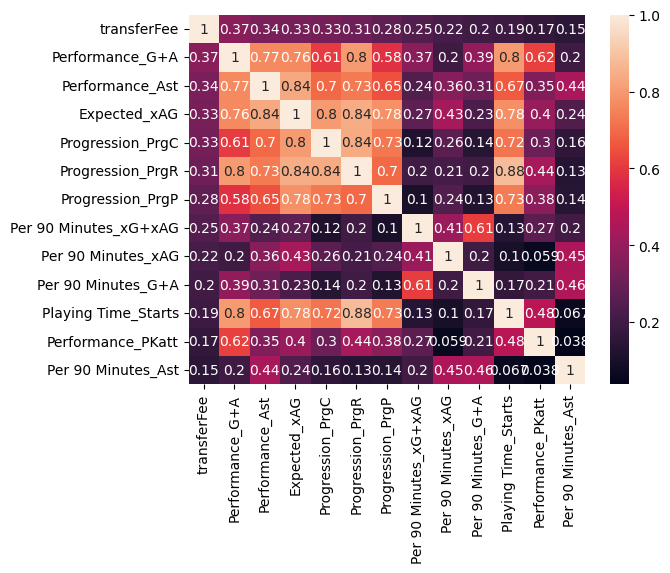

transferFee  Performance_G+A  Performance_Ast  \
transferFee               1.000000         0.369870         0.336699   
Performance_G+A           0.369870         1.000000         0.765979   
Performance_Ast           0.336699         0.765979         1.000000   
Expected_xAG              0.330141         0.763612         0.835193   
Progression_PrgC          0.325772         0.605530         0.698543   
Progression_PrgR          0.311326         0.800884         0.730229   
Progression_PrgP          0.277710         0.583848         0.648161   
Per 90 Minutes_xG+xAG     0.246327         0.369275         0.241017   
Per 90 Minutes_xAG        0.216970         0.197204         0.361684   
Per 90 Minutes_G+A        0.201584         0.389874         0.311445   
Playing Time_Starts       0.194246         0.802467         0.665817   
Performance_PKatt         0.166506         0.619605         0.351900   
Per 90 Minutes_Ast        0.153910         0.199033         0.436773   

                       Expected_xAG  Progression_PrgC  Progression_PrgR  \
transferFee                0.330141          0.325772          0.311326   
Performance_G+A            0.763612          0.605530          0.800884   
Performance_Ast            0.835193          0.698543          0.730229   
Expected_xAG               1.000000          0.802064          0.844314   
Progression_PrgC           0.802064          1.000000          0.841365   
Progression_PrgR           0.844314          0.841365          1.000000   
Progression_PrgP           0.778661          0.728379          0.698635   
Per 90 Minutes_xG+xAG      0.273685          0.117229          0.202788   
Per 90 Minutes_xAG         0.432655          0.263722          0.212872   
Per 90 Minutes_G+A         0.232785          0.138045          0.201575   
Playing Time_Starts        0.777187          0.719395          0.880142   
Performance_PKatt          0.404601          0.301198          0.435928   
Per 90 Minutes_Ast         0.239979          0.158358          0.132097   

                       Progression_PrgP  Per 90 Minutes_xG+xAG  \
transferFee                    0.277710               0.246327   
Performance_G+A                0.583848               0.369275   
Performance_Ast                0.648161               0.241017   
Expected_xAG                   0.778661               0.273685   
Progression_PrgC               0.728379               0.117229   
Progression_PrgR               0.698635               0.202788   
Progression_PrgP               1.000000               0.102224   
Per 90 Minutes_xG+xAG          0.102224               1.000000   
Per 90 Minutes_xAG             0.241562               0.407382   
Per 90 Minutes_G+A             0.128087               0.610398   
Playing Time_Starts            0.734348               0.134020   
Performance_PKatt              0.378704               0.267384   
Per 90 Minutes_Ast             0.135743               0.204005   

                       Per 90 Minutes_xAG  Per 90 Minutes_G+A  \
transferFee                      0.216970            0.201584   
Performance_G+A                  0.197204            0.389874   
Performance_Ast                  0.361684            0.311445   
Expected_xAG                     0.432655            0.232785   
Progression_PrgC                 0.263722            0.138045   
Progression_PrgR                 0.212872            0.201575   
Progression_PrgP                 0.241562            0.128087   
Per 90 Minutes_xG+xAG            0.407382            0.610398   
Per 90 Minutes_xAG               1.000000            0.199662   
Per 90 Minutes_G+A               0.199662            1.000000   
Playing Time_Starts              0.101569            0.165979   
Performance_PKatt                0.058548            0.206219   
Per 90 Minutes_Ast               0.450235            0.457207   

                       Playing Time_Starts  Performance_PKatt  \
transferFee                       0.194246           0.166506 

In [1535]:
removedAutocorrelations(df)


## Midfielders


In [1536]:
df = mid_stats["standard"]
df = removeExtraCols(df)
getBestCols(df)


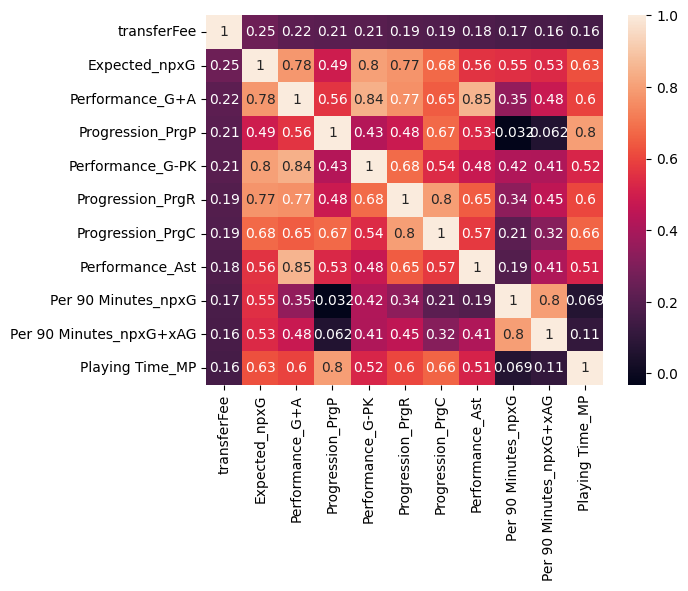

transferFee  Expected_npxG  Performance_G+A  \
transferFee                 1.000000       0.254645         0.215985   
Expected_npxG               0.254645       1.000000         0.779217   
Performance_G+A             0.215985       0.779217         1.000000   
Progression_PrgP            0.209321       0.489106         0.562304   
Performance_G-PK            0.205939       0.800578         0.840102   
Progression_PrgR            0.191420       0.771704         0.765025   
Progression_PrgC            0.186493       0.677186         0.645494   
Performance_Ast             0.181484       0.557219         0.853028   
Per 90 Minutes_npxG         0.167459       0.550796         0.346927   
Per 90 Minutes_npxG+xAG     0.161982       0.532880         0.477267   
Playing Time_MP             0.156507       0.625125         0.596333   

                         Progression_PrgP  Performance_G-PK  Progression_PrgR  \
transferFee                      0.209321          0.205939          0.191420   
Expected_npxG                    0.489106          0.800578          0.771704   
Performance_G+A                  0.562304          0.840102          0.765025   
Progression_PrgP                 1.000000          0.426786          0.483845   
Performance_G-PK                 0.426786          1.000000          0.680325   
Progression_PrgR                 0.483845          0.680325          1.000000   
Progression_PrgC                 0.674365          0.540272          0.797903   
Performance_Ast                  0.529530          0.475858          0.645567   
Per 90 Minutes_npxG             -0.031508          0.417425          0.337861   
Per 90 Minutes_npxG+xAG          0.061969          0.414886          0.453553   
Playing Time_MP                  0.795865          0.524513          0.604652   

                         Progression_PrgC  Performance_Ast  \
transferFee                      0.186493         0.181484   
Expected_npxG                    0.677186         0.557219   
Performance_G+A                  0.645494         0.853028   
Progression_PrgP                 0.674365         0.529530   
Performance_G-PK                 0.540272         0.475858   
Progression_PrgR                 0.797903         0.645567   
Progression_PrgC                 1.000000         0.573929   
Performance_Ast                  0.573929         1.000000   
Per 90 Minutes_npxG              0.210582         0.191451   
Per 90 Minutes_npxG+xAG          0.319031         0.411993   
Playing Time_MP                  0.662722         0.514825   

                         Per 90 Minutes_npxG  Per 90 Minutes_npxG+xAG  \
transferFee                         0.167459                 0.161982   
Expected_npxG                       0.550796                 0.532880   
Performance_G+A                     0.346927                 0.477267   
Progression_PrgP                   -0.031508                 0.061969   
Performance_G-PK                    0.417425                 0.414886   
Progression_PrgR                    0.337861                 0.453553   
Progression_PrgC                    0.210582                 0.319031   
Performance_Ast                     0.191451                 0.411993   
Per 90 Minutes_npxG                 1.000000                 0.795347   
Per 90 Minutes_npxG+xAG             0.795347                 1.000000   
Playing Time_MP                     0.068816                 0.106183   

                         Playing Time_MP  
transferFee                     0.156507  
Expected_npxG                   0.625125  
Performance_G+A                 0.596333  
Progression_PrgP                0.795865  
Performance_G-PK                0.524513  
Progression_PrgR                0.604652  
Progression_PrgC                0.662722  
Performance_Ast                 0.514825  
Per 90 Minutes_npxG             0.068816  
Per 90 Minutes_npxG+xAG         0.106183  
Playing Time_MP                 1.000000

In [ ]:
removedAutocorrelations(df)


## Defensors


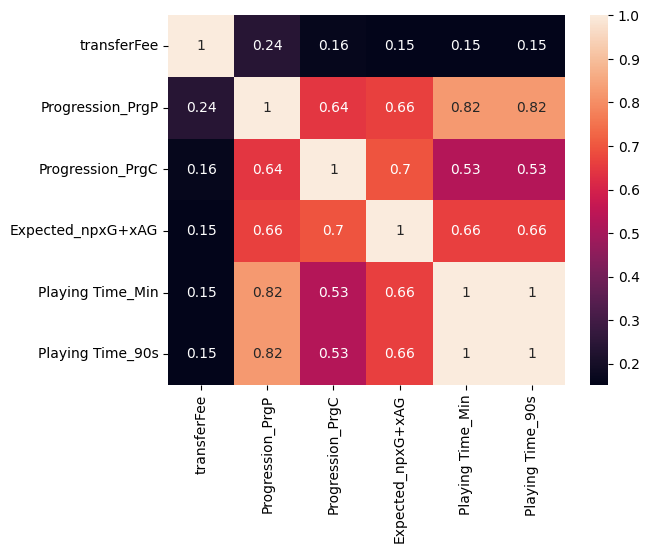

In [ ]:
df = def_stats["standard"]
df = removeExtraCols(df)
getBestCols(df)


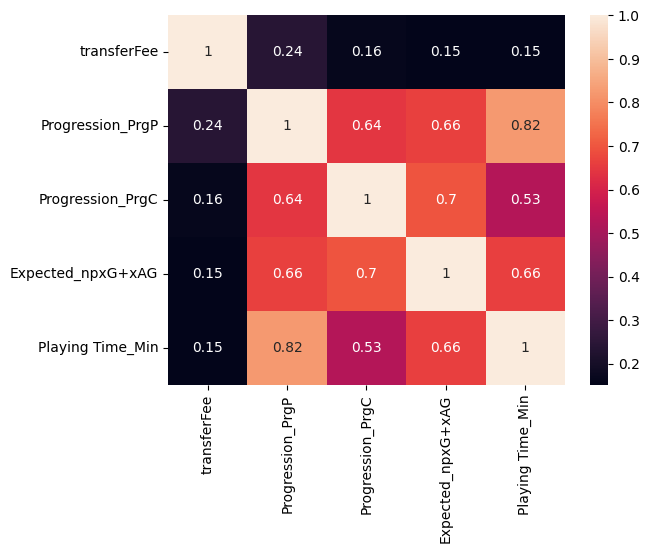

transferFee  Progression_PrgP  Progression_PrgC  \
transferFee           1.000000          0.240036          0.162969   
Progression_PrgP      0.240036          1.000000          0.642173   
Progression_PrgC      0.162969          0.642173          1.000000   
Expected_npxG+xAG     0.154651          0.663100          0.695591   
Playing Time_Min      0.151420          0.822765          0.526388   

                   Expected_npxG+xAG  Playing Time_Min  
transferFee                 0.154651          0.151420  
Progression_PrgP            0.663100          0.822765  
Progression_PrgC            0.695591          0.526388  
Expected_npxG+xAG           1.000000          0.659631  
Playing Time_Min            0.659631          1.000000

In [ ]:
removedAutocorrelations(df)


# Shooting


## All positions


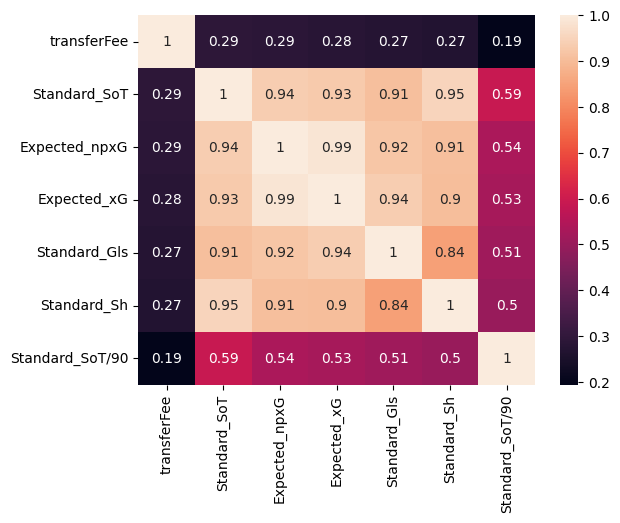

In [ ]:
df = all_pos_stats["shooting"]
df = removeExtraCols(df)
getBestCols(df)


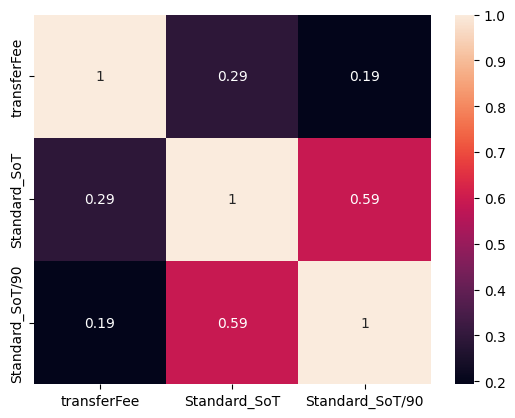

transferFee  Standard_SoT  Standard_SoT/90
transferFee         1.000000      0.289528         0.193577
Standard_SoT        0.289528      1.000000         0.587896
Standard_SoT/90     0.193577      0.587896         1.000000

In [ ]:
removedAutocorrelations(df)


## Attackers


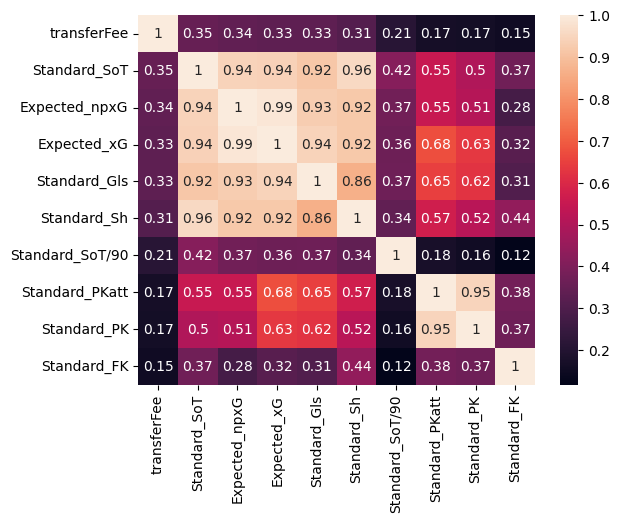

In [ ]:
df = atk_stats["shooting"]
df = removeExtraCols(df)
getBestCols(df)


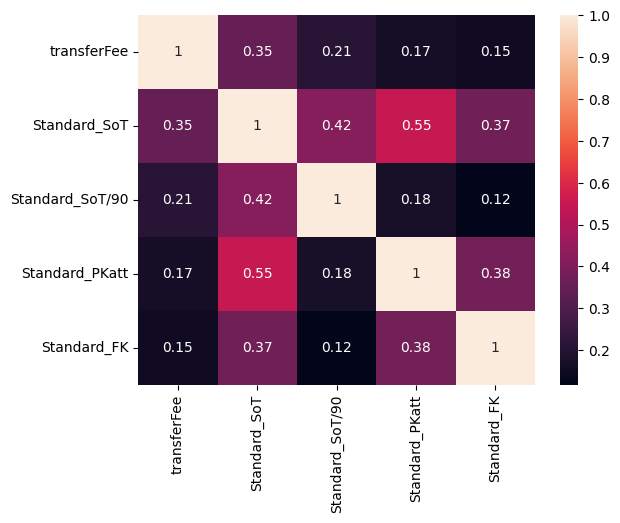

transferFee  Standard_SoT  Standard_SoT/90  Standard_PKatt  \
transferFee         1.000000      0.349072         0.211428        0.166506   
Standard_SoT        0.349072      1.000000         0.416311        0.551198   
Standard_SoT/90     0.211428      0.416311         1.000000        0.175266   
Standard_PKatt      0.166506      0.551198         0.175266        1.000000   
Standard_FK         0.154905      0.371438         0.117486        0.378133   

                 Standard_FK  
transferFee         0.154905  
Standard_SoT        0.371438  
Standard_SoT/90     0.117486  
Standard_PKatt      0.378133  
Standard_FK         1.000000

In [ ]:
removedAutocorrelations(df)


## Midfielders


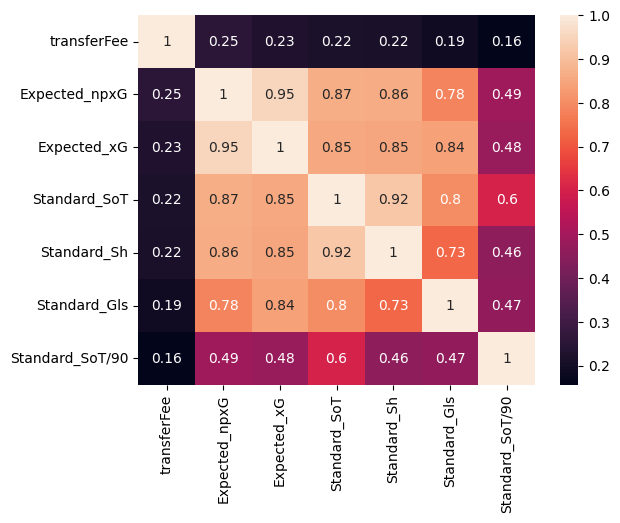

In [ ]:
df = mid_stats["shooting"]
df = removeExtraCols(df)
getBestCols(df)


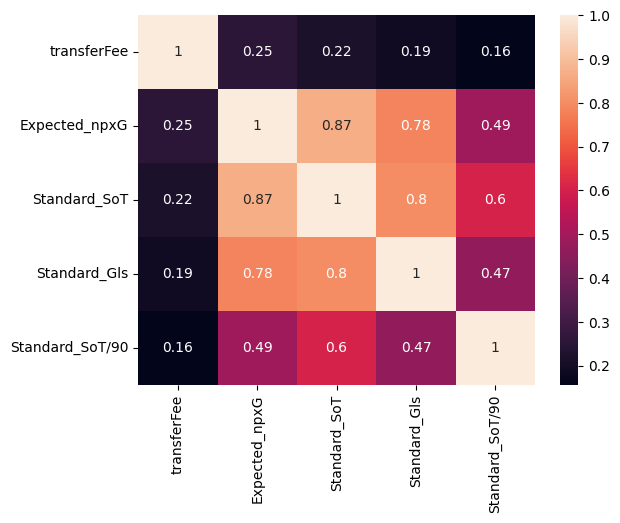

transferFee  Expected_npxG  Standard_SoT  Standard_Gls  \
transferFee         1.000000       0.254645      0.215628      0.192098   
Expected_npxG       0.254645       1.000000      0.865805      0.782442   
Standard_SoT        0.215628       0.865805      1.000000      0.799329   
Standard_Gls        0.192098       0.782442      0.799329      1.000000   
Standard_SoT/90     0.155982       0.492007      0.601471      0.465681   

                 Standard_SoT/90  
transferFee             0.155982  
Expected_npxG           0.492007  
Standard_SoT            0.601471  
Standard_Gls            0.465681  
Standard_SoT/90         1.000000

In [ ]:
removedAutocorrelations(df)


## Defensors


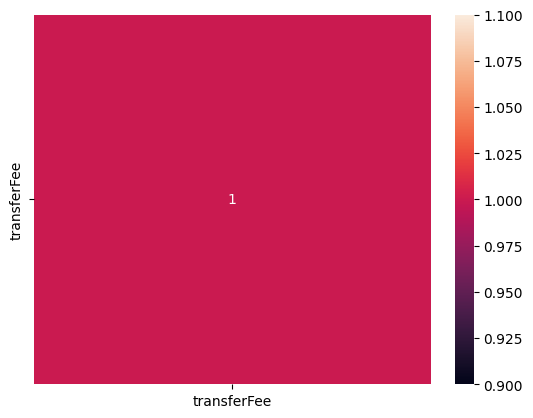

In [ ]:
df = def_stats["shooting"]
df = removeExtraCols(df)
getBestCols(df)


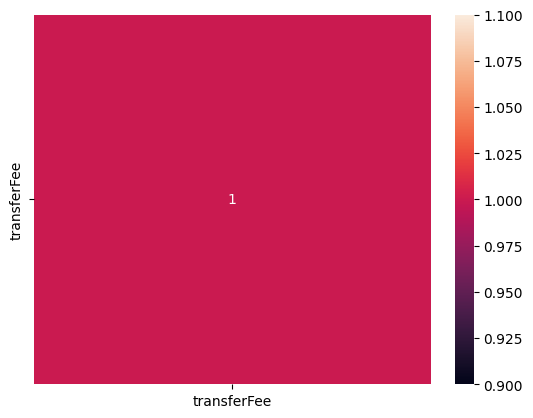

transferFee
transferFee          1.0

In [ ]:
removedAutocorrelations(df)


# Goal shot creation


In [ ]:
type = "goal_shot_creation"

## All positions


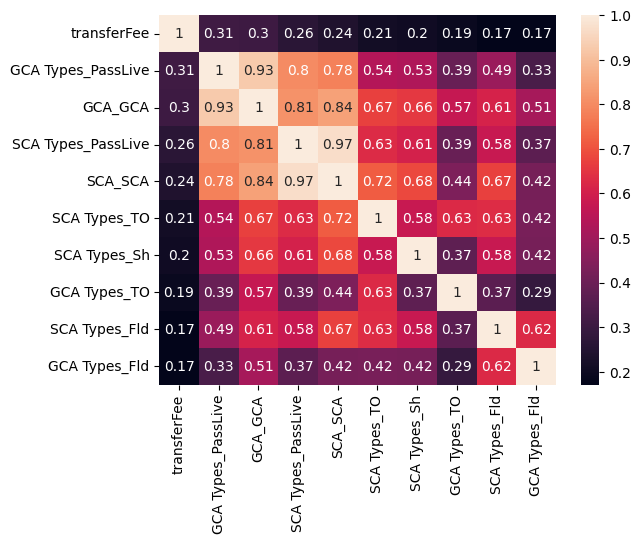

In [ ]:
df = all_pos_stats[type]
df = removeExtraCols(df)
getBestCols(df)

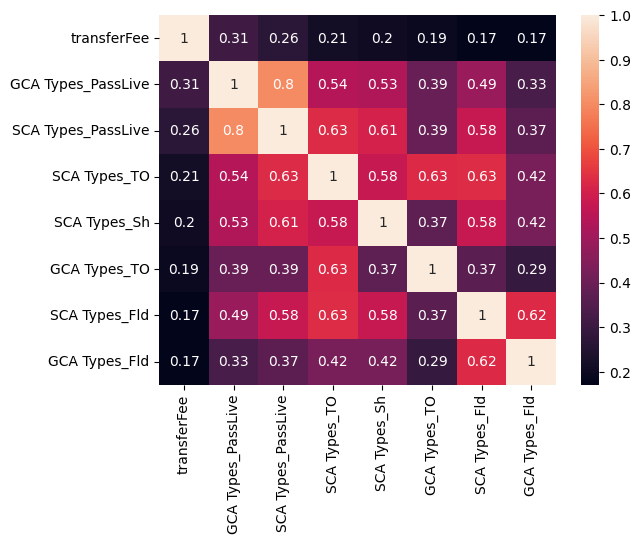

transferFee  GCA Types_PassLive  SCA Types_PassLive  \
transferFee            1.000000            0.307290            0.263949   
GCA Types_PassLive     0.307290            1.000000            0.799768   
SCA Types_PassLive     0.263949            0.799768            1.000000   
SCA Types_TO           0.210069            0.538658            0.630003   
SCA Types_Sh           0.204748            0.527462            0.607073   
GCA Types_TO           0.190554            0.393086            0.391860   
SCA Types_Fld          0.171036            0.489307            0.578130   
GCA Types_Fld          0.170696            0.329999            0.371469   

                    SCA Types_TO  SCA Types_Sh  GCA Types_TO  SCA Types_Fld  \
transferFee             0.210069      0.204748      0.190554       0.171036   
GCA Types_PassLive      0.538658      0.527462      0.393086       0.489307   
SCA Types_PassLive      0.630003      0.607073      0.391860       0.578130   
SCA Types_TO            1.000000      0.576081      0.626245       0.632264   
SCA Types_Sh            0.576081      1.000000      0.374556       0.576606   
GCA Types_TO            0.626245      0.374556      1.000000       0.367266   
SCA Types_Fld           0.632264      0.576606      0.367266       1.000000   
GCA Types_Fld           0.424523      0.421593      0.289189       0.624950   

                    GCA Types_Fld  
transferFee              0.170696  
GCA Types_PassLive       0.329999  
SCA Types_PassLive       0.371469  
SCA Types_TO             0.424523  
SCA Types_Sh             0.421593  
GCA Types_TO             0.289189  
SCA Types_Fld            0.624950  
GCA Types_Fld            1.000000

In [ ]:
removedAutocorrelations(df)


## Attackers


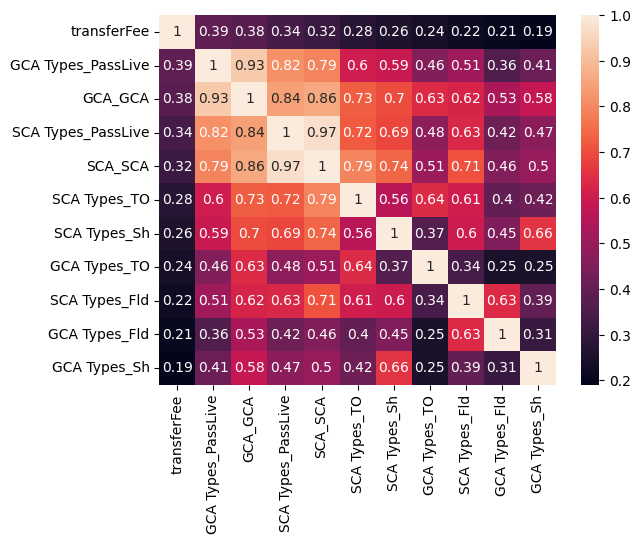

In [ ]:
df = atk_stats[type]
df = removeExtraCols(df)
getBestCols(df)


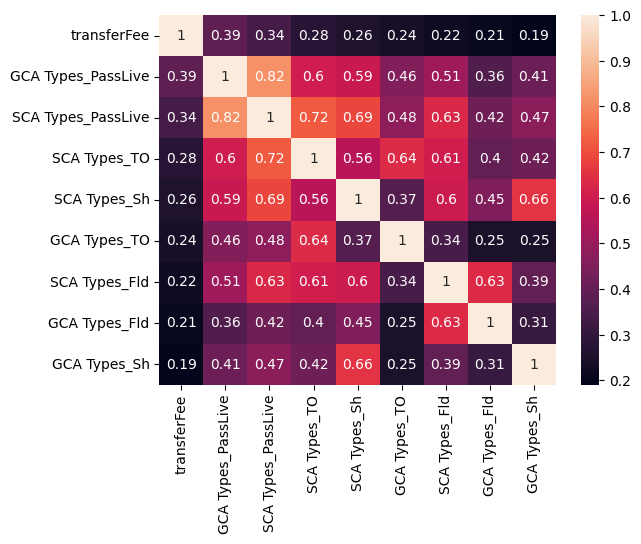

transferFee  GCA Types_PassLive  SCA Types_PassLive  \
transferFee            1.000000            0.392169            0.337834   
GCA Types_PassLive     0.392169            1.000000            0.815511   
SCA Types_PassLive     0.337834            0.815511            1.000000   
SCA Types_TO           0.278361            0.602815            0.721166   
SCA Types_Sh           0.255874            0.589617            0.688439   
GCA Types_TO           0.240364            0.457925            0.480509   
SCA Types_Fld          0.221930            0.512258            0.630655   
GCA Types_Fld          0.208208            0.358080            0.415935   
GCA Types_Sh           0.190433            0.414785            0.473479   

                    SCA Types_TO  SCA Types_Sh  GCA Types_TO  SCA Types_Fld  \
transferFee             0.278361      0.255874      0.240364       0.221930   
GCA Types_PassLive      0.602815      0.589617      0.457925       0.512258   
SCA Types_PassLive      0.721166      0.688439      0.480509       0.630655   
SCA Types_TO            1.000000      0.557709      0.637223       0.606375   
SCA Types_Sh            0.557709      1.000000      0.370347       0.596868   
GCA Types_TO            0.637223      0.370347      1.000000       0.344710   
SCA Types_Fld           0.606375      0.596868      0.344710       1.000000   
GCA Types_Fld           0.396765      0.452356      0.247706       0.634900   
GCA Types_Sh            0.417162      0.658218      0.247634       0.394771   

                    GCA Types_Fld  GCA Types_Sh  
transferFee              0.208208      0.190433  
GCA Types_PassLive       0.358080      0.414785  
SCA Types_PassLive       0.415935      0.473479  
SCA Types_TO             0.396765      0.417162  
SCA Types_Sh             0.452356      0.658218  
GCA Types_TO             0.247706      0.247634  
SCA Types_Fld            0.634900      0.394771  
GCA Types_Fld            1.000000      0.312280  
GCA Types_Sh             0.312280      1.000000

In [ ]:
removedAutocorrelations(df)


## Midfielders


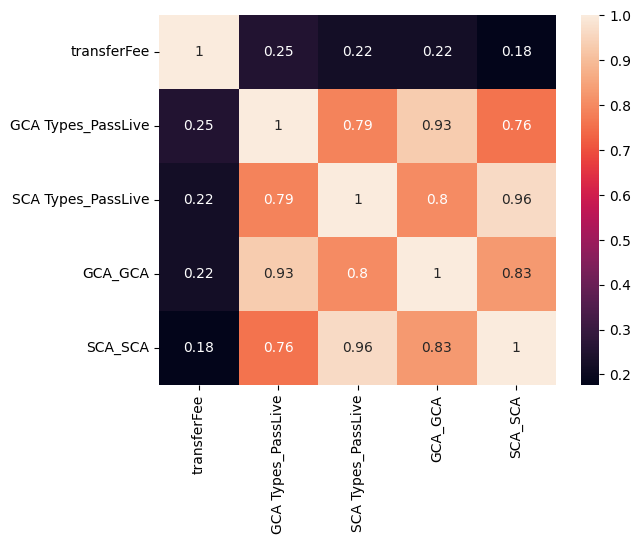

In [ ]:
df = mid_stats[type]
df = removeExtraCols(df)
getBestCols(df)


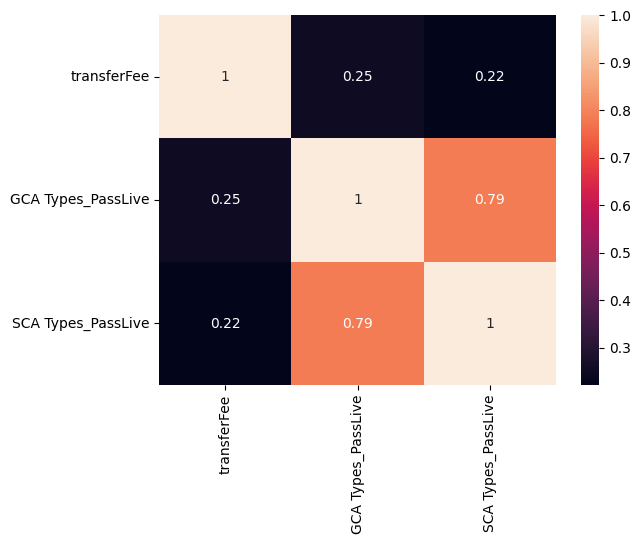

transferFee  GCA Types_PassLive  SCA Types_PassLive
transferFee            1.000000            0.251665            0.221654
GCA Types_PassLive     0.251665            1.000000            0.785651
SCA Types_PassLive     0.221654            0.785651            1.000000

In [ ]:
removedAutocorrelations(df)


## Defensors


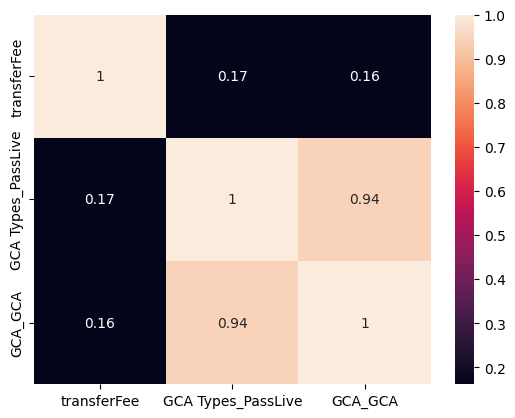

In [ ]:
df = def_stats[type]
df = removeExtraCols(df)
getBestCols(df)


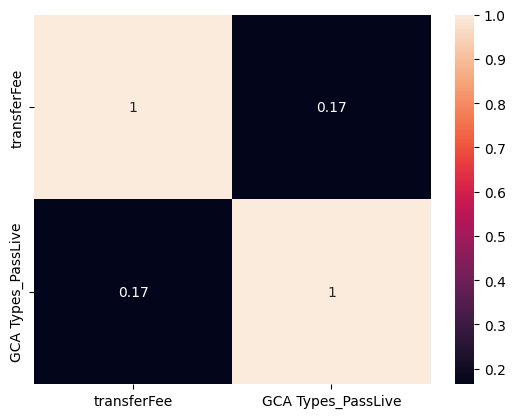

transferFee  GCA Types_PassLive
transferFee            1.000000            0.165069
GCA Types_PassLive     0.165069            1.000000

In [ ]:
removedAutocorrelations(df)


# Passing


In [ ]:
type = "passing"

## All positions


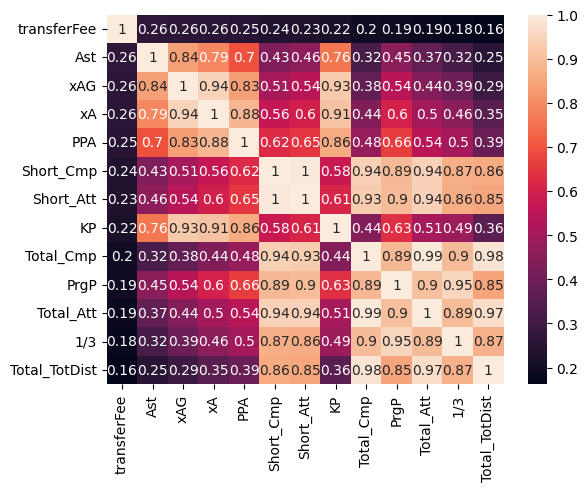

In [ ]:
df = all_pos_stats[type]
df = removeExtraCols(df)
getBestCols(df)

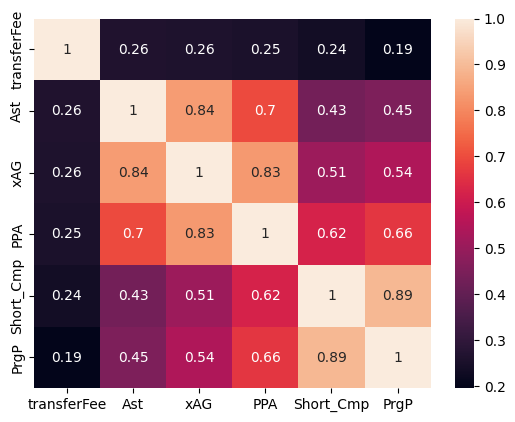

transferFee       Ast       xAG       PPA  Short_Cmp      PrgP
transferFee     1.000000  0.263530  0.258773  0.252102   0.235472  0.194783
Ast             0.263530  1.000000  0.836598  0.697235   0.430873  0.451494
xAG             0.258773  0.836598  1.000000  0.833255   0.508072  0.543408
PPA             0.252102  0.697235  0.833255  1.000000   0.620788  0.660545
Short_Cmp       0.235472  0.430873  0.508072  0.620788   1.000000  0.891404
PrgP            0.194783  0.451494  0.543408  0.660545   0.891404  1.000000

In [ ]:
removedAutocorrelations(df)


## Attackers


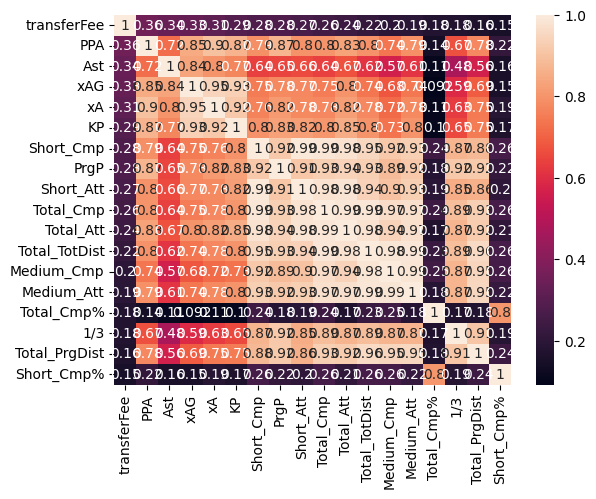

In [ ]:
df = atk_stats[type]
df = removeExtraCols(df)
getBestCols(df)


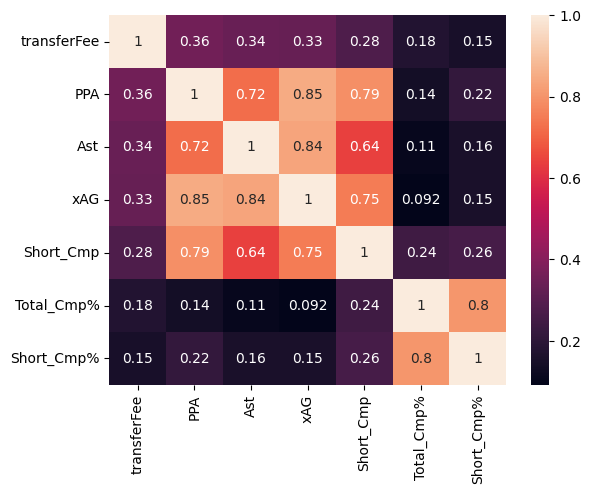

transferFee       PPA       Ast       xAG  Short_Cmp  Total_Cmp%  \
transferFee     1.000000  0.355454  0.336699  0.330141   0.277725    0.177042   
PPA             0.355454  1.000000  0.720697  0.849207   0.788056    0.141550   
Ast             0.336699  0.720697  1.000000  0.835193   0.641757    0.109558   
xAG             0.330141  0.849207  0.835193  1.000000   0.750954    0.092262   
Short_Cmp       0.277725  0.788056  0.641757  0.750954   1.000000    0.241323   
Total_Cmp%      0.177042  0.141550  0.109558  0.092262   0.241323    1.000000   
Short_Cmp%      0.151183  0.216228  0.155750  0.154584   0.259083    0.802184   

             Short_Cmp%  
transferFee    0.151183  
PPA            0.216228  
Ast            0.155750  
xAG            0.154584  
Short_Cmp      0.259083  
Total_Cmp%     0.802184  
Short_Cmp%     1.000000

In [ ]:
removedAutocorrelations(df)


## Midfielders


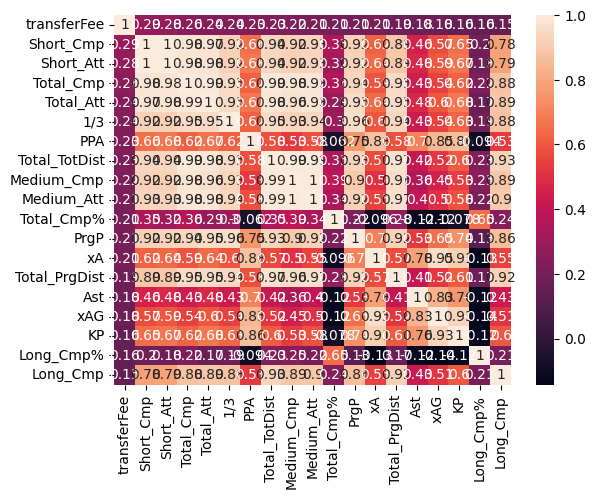

In [ ]:
df = mid_stats[type]
df = removeExtraCols(df)
getBestCols(df)


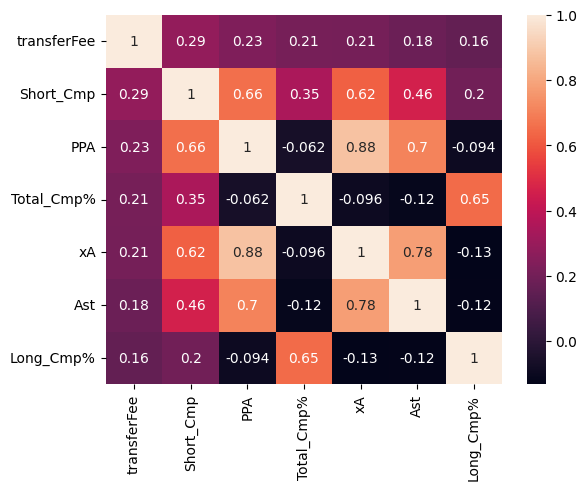

transferFee  Short_Cmp       PPA  Total_Cmp%        xA       Ast  \
transferFee     1.000000   0.286475  0.232510    0.209739  0.206539  0.181484   
Short_Cmp       0.286475   1.000000  0.655791    0.349484  0.621433  0.458325   
PPA             0.232510   0.655791  1.000000   -0.061687  0.877991  0.704478   
Total_Cmp%      0.209739   0.349484 -0.061687    1.000000 -0.095898 -0.117352   
xA              0.206539   0.621433  0.877991   -0.095898  1.000000  0.778559   
Ast             0.181484   0.458325  0.704478   -0.117352  0.778559  1.000000   
Long_Cmp%       0.156545   0.195238 -0.094124    0.647519 -0.132195 -0.124397   

             Long_Cmp%  
transferFee   0.156545  
Short_Cmp     0.195238  
PPA          -0.094124  
Total_Cmp%    0.647519  
xA           -0.132195  
Ast          -0.124397  
Long_Cmp%     1.000000

In [ ]:
removedAutocorrelations(df)


## Defensors


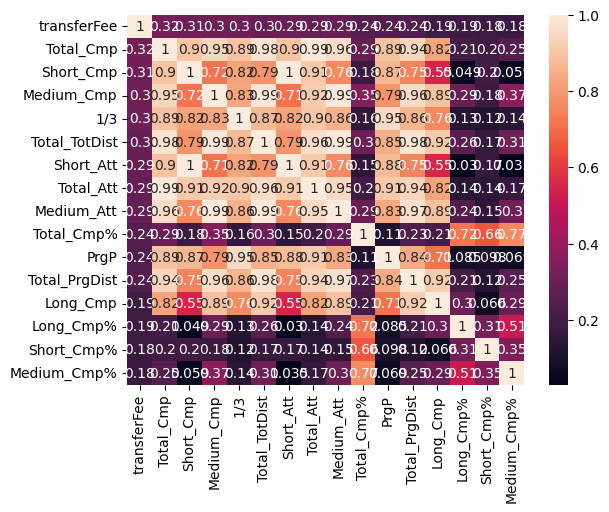

In [ ]:
df = def_stats[type]
df = removeExtraCols(df)
getBestCols(df)


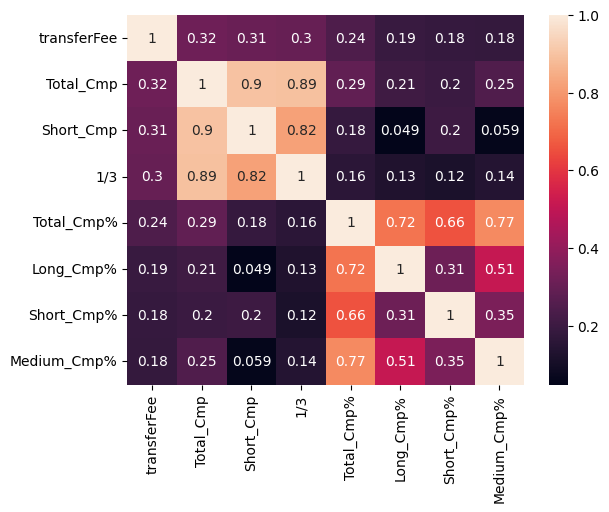

transferFee  Total_Cmp  Short_Cmp       1/3  Total_Cmp%  \
transferFee     1.000000   0.318685   0.305573  0.299823    0.243523   
Total_Cmp       0.318685   1.000000   0.899636  0.894248    0.289696   
Short_Cmp       0.305573   0.899636   1.000000  0.820910    0.182512   
1/3             0.299823   0.894248   0.820910  1.000000    0.159469   
Total_Cmp%      0.243523   0.289696   0.182512  0.159469    1.000000   
Long_Cmp%       0.192728   0.206293   0.048706  0.127035    0.721929   
Short_Cmp%      0.183121   0.196367   0.204068  0.118843    0.657934   
Medium_Cmp%     0.179669   0.247220   0.059166  0.137909    0.765932   

             Long_Cmp%  Short_Cmp%  Medium_Cmp%  
transferFee   0.192728    0.183121     0.179669  
Total_Cmp     0.206293    0.196367     0.247220  
Short_Cmp     0.048706    0.204068     0.059166  
1/3           0.127035    0.118843     0.137909  
Total_Cmp%    0.721929    0.657934     0.765932  
Long_Cmp%     1.000000    0.314993     0.512942  
Short_Cmp%    0.314993    1.000000     0.346448  
Medium_Cmp%   0.512942    0.346448     1.000000

In [ ]:
removedAutocorrelations(df)


# Possession


In [ ]:
type = "possession"

## All positions


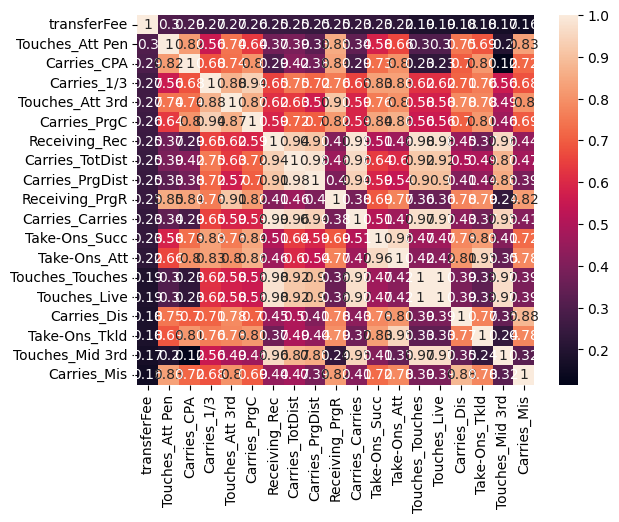

In [ ]:
df = all_pos_stats[type]
df = removeExtraCols(df)
getBestCols(df)

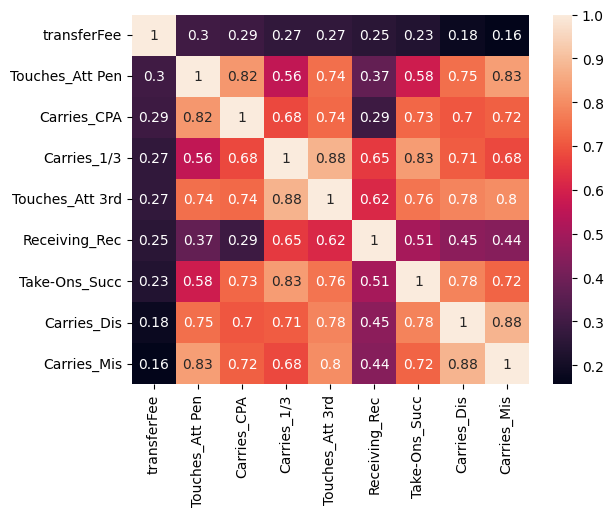

transferFee  Touches_Att Pen  Carries_CPA  Carries_1/3  \
transferFee         1.000000         0.300920     0.294828     0.267779   
Touches_Att Pen     0.300920         1.000000     0.821561     0.557965   
Carries_CPA         0.294828         0.821561     1.000000     0.679975   
Carries_1/3         0.267779         0.557965     0.679975     1.000000   
Touches_Att 3rd     0.266096         0.743452     0.736448     0.875287   
Receiving_Rec       0.250850         0.373833     0.294756     0.653527   
Take-Ons_Succ       0.233782         0.583643     0.732590     0.831666   
Carries_Dis         0.181241         0.745020     0.702675     0.710703   
Carries_Mis         0.156742         0.834047     0.719090     0.679409   

                 Touches_Att 3rd  Receiving_Rec  Take-Ons_Succ  Carries_Dis  \
transferFee             0.266096       0.250850       0.233782     0.181241   
Touches_Att Pen         0.743452       0.373833       0.583643     0.745020   
Carries_CPA             0.736448       0.294756       0.732590     0.702675   
Carries_1/3             0.875287       0.653527       0.831666     0.710703   
Touches_Att 3rd         1.000000       0.616223       0.756052     0.784070   
Receiving_Rec           0.616223       1.000000       0.505636     0.453203   
Take-Ons_Succ           0.756052       0.505636       1.000000     0.780947   
Carries_Dis             0.784070       0.453203       0.780947     1.000000   
Carries_Mis             0.800489       0.442033       0.724782     0.879215   

                 Carries_Mis  
transferFee         0.156742  
Touches_Att Pen     0.834047  
Carries_CPA         0.719090  
Carries_1/3         0.679409  
Touches_Att 3rd     0.800489  
Receiving_Rec       0.442033  
Take-Ons_Succ       0.724782  
Carries_Dis         0.879215  
Carries_Mis         1.000000

In [ ]:
removedAutocorrelations(df)


## Attackers


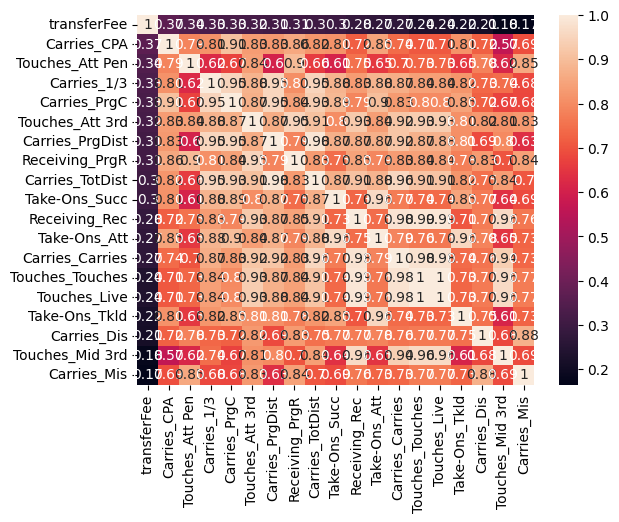

In [ ]:
df = atk_stats[type]
df = removeExtraCols(df)
getBestCols(df)


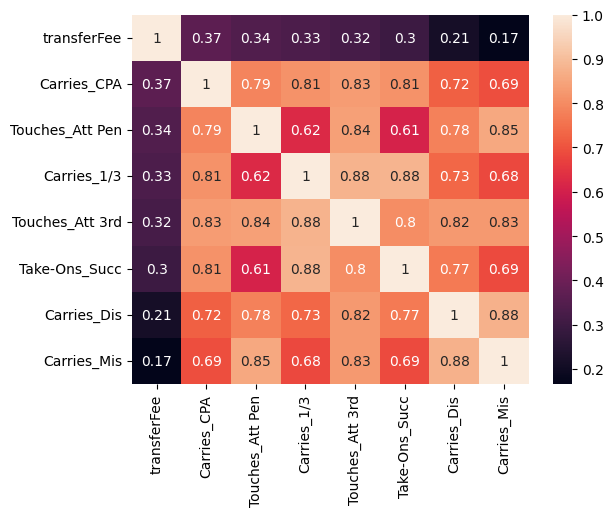

transferFee  Carries_CPA  Touches_Att Pen  Carries_1/3  \
transferFee         1.000000     0.365710         0.344430     0.332271   
Carries_CPA         0.365710     1.000000         0.786151     0.813564   
Touches_Att Pen     0.344430     0.786151         1.000000     0.623883   
Carries_1/3         0.332271     0.813564         0.623883     1.000000   
Touches_Att 3rd     0.321482     0.831951         0.839747     0.876618   
Take-Ons_Succ       0.299439     0.812057         0.607091     0.882529   
Carries_Dis         0.211921     0.722297         0.780145     0.734165   
Carries_Mis         0.165905     0.690995         0.853953     0.682335   

                 Touches_Att 3rd  Take-Ons_Succ  Carries_Dis  Carries_Mis  
transferFee             0.321482       0.299439     0.211921     0.165905  
Carries_CPA             0.831951       0.812057     0.722297     0.690995  
Touches_Att Pen         0.839747       0.607091     0.780145     0.853953  
Carries_1/3             0.876618       0.882529     0.734165     0.682335  
Touches_Att 3rd         1.000000       0.801993     0.824260     0.826560  
Take-Ons_Succ           0.801993       1.000000     0.766602     0.686236  
Carries_Dis             0.824260       0.766602     1.000000     0.876036  
Carries_Mis             0.826560       0.686236     0.876036     1.000000

In [ ]:
removedAutocorrelations(df)


## Midfielders


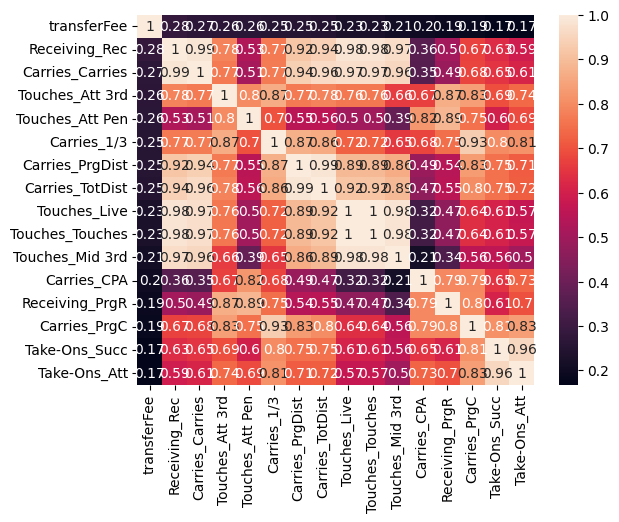

In [ ]:
df = mid_stats[type]
df = removeExtraCols(df)
getBestCols(df)


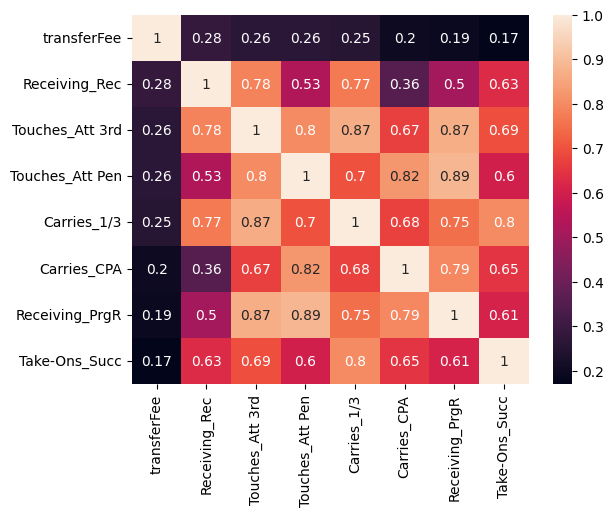

transferFee  Receiving_Rec  Touches_Att 3rd  Touches_Att Pen  \
transferFee         1.000000       0.282956         0.263347         0.260244   
Receiving_Rec       0.282956       1.000000         0.783081         0.526966   
Touches_Att 3rd     0.263347       0.783081         1.000000         0.801284   
Touches_Att Pen     0.260244       0.526966         0.801284         1.000000   
Carries_1/3         0.254285       0.766841         0.865841         0.699915   
Carries_CPA         0.197703       0.357494         0.668643         0.822959   
Receiving_PrgR      0.191420       0.504670         0.868827         0.886252   
Take-Ons_Succ       0.169373       0.629846         0.693141         0.599621   

                 Carries_1/3  Carries_CPA  Receiving_PrgR  Take-Ons_Succ  
transferFee         0.254285     0.197703        0.191420       0.169373  
Receiving_Rec       0.766841     0.357494        0.504670       0.629846  
Touches_Att 3rd     0.865841     0.668643        0.868827       0.693141  
Touches_Att Pen     0.699915     0.822959        0.886252       0.599621  
Carries_1/3         1.000000     0.675159        0.749215       0.799647  
Carries_CPA         0.675159     1.000000        0.793804       0.648898  
Receiving_PrgR      0.749215     0.793804        1.000000       0.608660  
Take-Ons_Succ       0.799647     0.648898        0.608660       1.000000

In [ ]:
removedAutocorrelations(df)


## Defensors


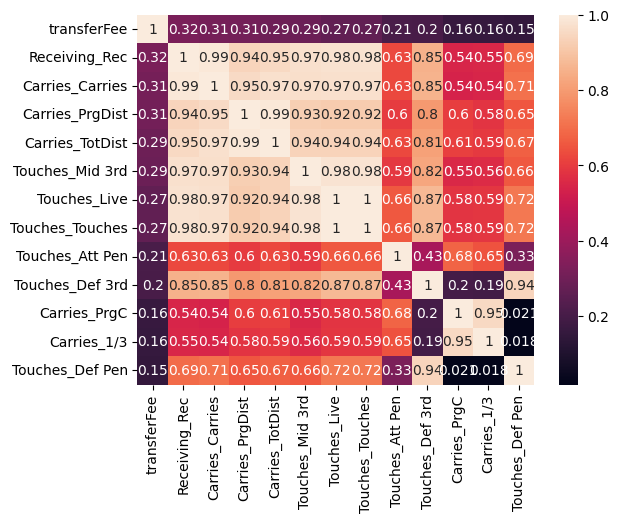

In [ ]:
df = def_stats[type]
df = removeExtraCols(df)
getBestCols(df)


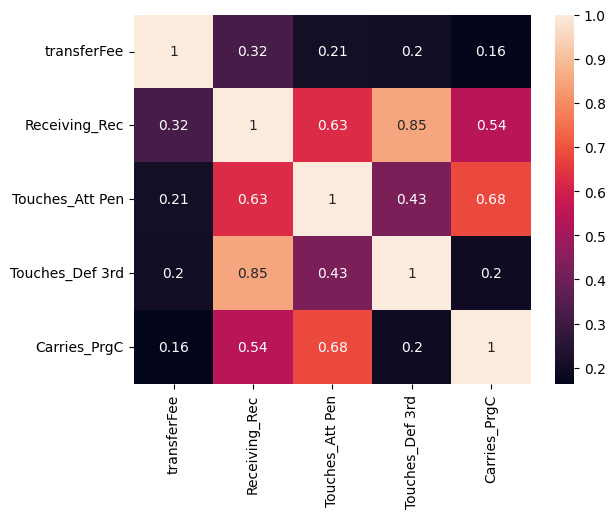

transferFee  Receiving_Rec  Touches_Att Pen  Touches_Def 3rd  \
transferFee         1.000000       0.323136         0.206429         0.203106   
Receiving_Rec       0.323136       1.000000         0.627197         0.852209   
Touches_Att Pen     0.206429       0.627197         1.000000         0.426436   
Touches_Def 3rd     0.203106       0.852209         0.426436         1.000000   
Carries_PrgC        0.162969       0.544451         0.680663         0.196986   

                 Carries_PrgC  
transferFee          0.162969  
Receiving_Rec        0.544451  
Touches_Att Pen      0.680663  
Touches_Def 3rd      0.196986  
Carries_PrgC         1.000000

In [ ]:
removedAutocorrelations(df)


# All stats


In [ ]:
type = "all"

## All positions


In [ ]:
df = all_pos_stats[type]
df = removeExtraCols(df)
df

transferFee  Playing Time_MP  Playing Time_Starts  Playing Time_Min  \
0         2800000                1                    0                11   
1        42000000               31                   29              2534   
2        52700000               32                   32              2785   
4        12000000               15                    1               309   
5         3800000               12                    2               383   
...           ...              ...                  ...               ...   
2669      1500000                5                    1               146   
2670      3000000               33                   29              2653   
2671       300000               11                    8               707   
2672      1750000               34                   27              2431   
2673       500000                6                    3               254   

      Playing Time_90s  Performance_Gls  Performance_Ast  Performance_G+A  \
0                  0.1                0                0                0   
1                 28.2                0                0                0   
2                 30.9                0                6                6   
4                  3.4                0                0                0   
5                  4.3                0                0                0   
...                ...              ...              ...              ...   
2669               1.6                0                0                0   
2670              29.5                3                0                3   
2671               7.9                0                0                0   
2672              27.0                2                1                3   
2673               2.8                1                0                1   

      Performance_G-PK  Performance_PK  ...  Performance_Crs  Performance_Int  \
0                    0               0  ...              0.0              0.0   
1                    0               0  ...              3.0             38.0   
2                    0               0  ...             56.0             29.0   
4                    0               0  ...              8.0              4.0   
5                    0               0  ...              4.0              1.0   
...                ...             ...  ...              ...              ...   
2669                 0               0  ...              6.0              1.0   
2670                 3               0  ...             19.0             17.0   
2671                 0               0  ...              0.0             11.0   
2672                 2               0  ...             33.0             39.0   
2673                 1               0  ...              1.0              0.0   

      Performance_TklW  Performance_PKwon  Performance_PKcon  Performance_OG  \
0                  1.0                0.0                0.0             0.0   
1                 24.0                0.0                0.0             1.0   
2                 31.0                0.0                0.0             1.0   
4                  9.0                0.0                0.0             0.0   
5                  3.0                2.0                0.0             0.0   
...                ...                ...                ...             ...   
2669               1.0                0.0                0.0             0.0   
2670              35.0                0.0                0.0             1.0   
2671               5.0                1.0                0.0             0.0   
2672              23.0                0.0                0.0             1.0   
2673               1.0                0.0                0.0             0.0   

      Performance_Recov  Aerial Duels_Won  Aerial Duels_Lost  \
0                   0.0               1.0                2.0   
1                 164.0              73.0               61.0   
2                 175.0       

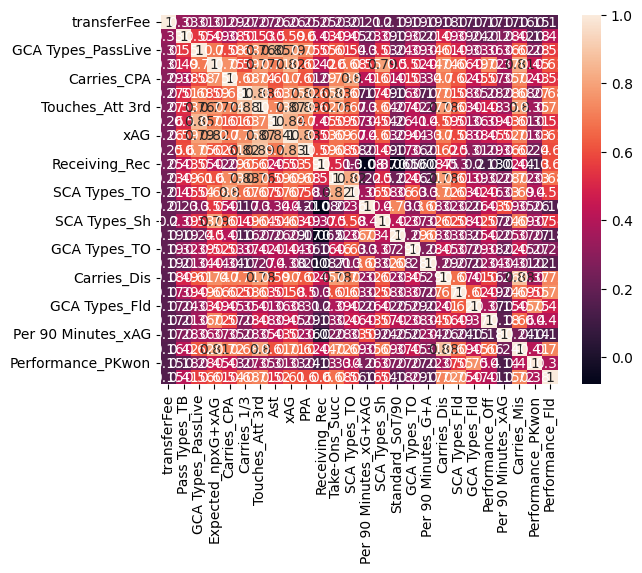

transferFee  Pass Types_TB  GCA Types_PassLive  \
transferFee               1.000000       0.330521            0.307290   
Pass Types_TB             0.330521       1.000000            0.548302   
GCA Types_PassLive        0.307290       0.548302            1.000000   
Expected_npxG+xAG         0.307256       0.488110            0.695880   
Carries_CPA               0.294828       0.375759            0.583324   
Carries_1/3               0.267779       0.512894            0.681906   
Touches_Att 3rd           0.266096       0.525573            0.762633   
Ast                       0.263530       0.503128            0.852660   
xAG                       0.258773       0.590208            0.791061   
PPA                       0.252102       0.597613            0.745076   
Receiving_Rec             0.250850       0.428941            0.549066   
Take-Ons_Succ             0.233782       0.494103            0.614803   
SCA Types_TO              0.210069       0.446069            0.538658   
Per 90 Minutes_xG+xAG     0.209301       0.229846            0.295111   
SCA Types_Sh              0.204748       0.392338            0.527462   
Standard_SoT/90           0.193577       0.188255            0.241746   
GCA Types_TO              0.190554       0.322984            0.393086   
Per 90 Minutes_G+A        0.185849       0.211022            0.339732   
Carries_Dis               0.181241       0.491524            0.612760   
SCA Types_Fld             0.171036       0.386435            0.489307   
GCA Types_Fld             0.170696       0.240656            0.329999   
Performance_Off           0.170357       0.211858            0.361330   
Per 90 Minutes_xAG        0.165816       0.280985            0.358566   
Carries_Mis               0.156742       0.416617            0.623936   
Performance_PKwon         0.154685       0.180926            0.282098   
Performance_Fld           0.154447       0.410170            0.557188   

                       Expected_npxG+xAG  Carries_CPA  Carries_1/3  \
transferFee                     0.307256     0.294828     0.267779   
Pass Types_TB                   0.488110     0.375759     0.512894   
GCA Types_PassLive              0.695880     0.583324     0.681906   
Expected_npxG+xAG               1.000000     0.754239     0.594576   
Carries_CPA                     0.754239     1.000000     0.679975   
Carries_1/3                     0.594576     0.679975     1.000000   
Touches_Att 3rd                 0.774819     0.736448     0.875287   
Ast                             0.710602     0.609121     0.626686   
xAG                             0.824146     0.699317     0.750921   
PPA                             0.621428     0.608631     0.824526   
Receiving_Rec                   0.416035     0.294756     0.653527   
Take-Ons_Succ                   0.601065     0.732590     0.831666   
SCA Types_TO                    0.683921     0.797318     0.672499   
Per 90 Minutes_xG+xAG           0.550133     0.413576     0.169553   
SCA Types_Sh                    0.792797     0.608246     0.493851   
Standard_SoT/90                 0.496077     0.405316     0.159184   
GCA Types_TO                    0.521315     0.526635     0.374114   
Per 90 Minutes_G+A              0.444232     0.335505     0.171385   
Carries_Dis                     0.743722     0.702675     0.710703   
SCA Types_Fld                   0.656981     0.620033     0.576841   
GCA Types_Fld                   0.485073     0.445046     0.352013   
Performance_Off                 0.723770     0.568914     0.281128   
Per 90 Minutes_xAG              0.370926     0.345707     0.280618   
Carries_Mis                     0.810905     0.719090     0.679409   
Performance_PKwon               0.448265     0.431552     0.270304   
Performance_Fld                 0.610243     0.536931     0.684876   

                       Touches_Att 3rd       Ast       xAG       PPA  ...  \
transferFee                   0.266096  0.263530  0.258773  0.252102  ...   
Pass T

In [ ]:
removedAutocorrelations(df)


## Attackers


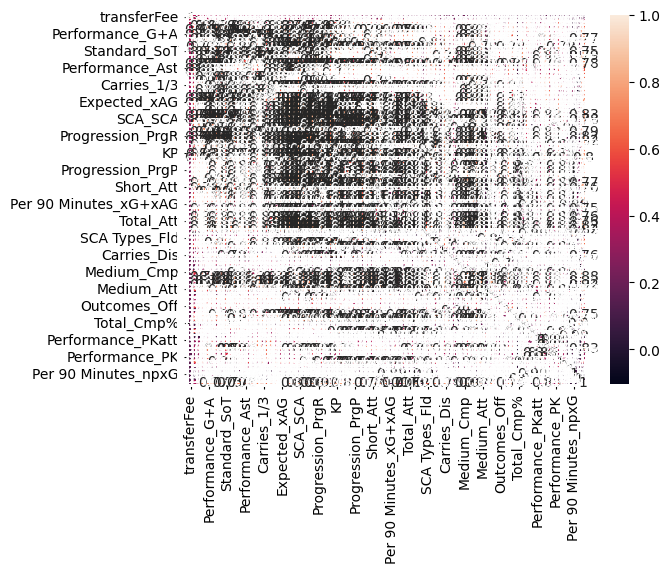

In [ ]:
df = atk_stats[type]
model_df = df.copy()
df = removeExtraCols(df)
getBestCols(df)


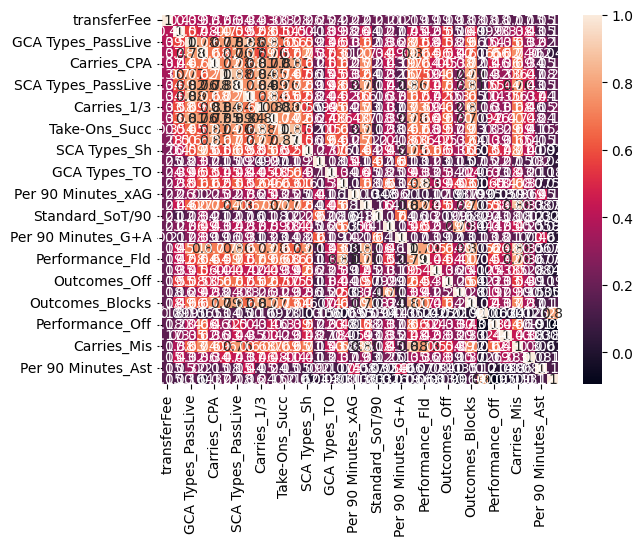

In [ ]:
corr_matrix = removedAutocorrelations(df)


In [ ]:
column_correlations = corr_matrix['transferFee']

# Calcular os valores absolutos das correlações
abs_correlations = column_correlations.abs()

# Ordenar os valores absolutos em ordem decrescente
sorted_correlations = abs_correlations.sort_values(ascending=False)

# Obter as maiores correlações
top_correlations = sorted_correlations

print(top_correlations)

transferFee              1.000000
Pass Types_TB            0.398908
GCA Types_PassLive       0.392169
Performance_G+A          0.369870
Carries_CPA              0.365710
PPA                      0.355454
SCA Types_PassLive       0.337834
Ast                      0.336699
Carries_1/3              0.332271
xAG                      0.330141
Take-Ons_Succ            0.299439
SCA Types_TO             0.278361
SCA Types_Sh             0.255874
Per 90 Minutes_xG+xAG    0.246327
GCA Types_TO             0.240364
SCA Types_Fld            0.221930
Per 90 Minutes_xAG       0.216970
Carries_Dis              0.211921
Standard_SoT/90          0.211428
GCA Types_Fld            0.208208
Per 90 Minutes_G+A       0.201584
Playing Time_Starts      0.194246
Performance_Fld          0.191511
GCA Types_Sh             0.190433
Outcomes_Off             0.185029
Performance_PKwon        0.183392
Outcomes_Blocks          0.182912
Total_Cmp%               0.177042
Performance_Off          0.177022
Standard_PKatt

In [ ]:
top_corr = list(top_correlations.index)
columns = model_df.columns.intersection(detailed_transfers_mod.columns)
columns = list(columns)
filtered = filter(lambda i: not i.startswith('playerPos'), columns)
filtered = list(filtered)
selected_cols = list(np.concatenate((filtered, top_corr)))
selected_cols.remove('transferFee')
selected_cols.remove('transferFee')
df = model_df
df = df.dropna()
X = df[selected_cols]  # Features
y = df['transferFee']  # Alvo


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)


y_pred = model.predict(X_test_scaled)

mse = r2_score(y_test, y_pred)
print('Coeficiente de correlação:', mse)

Coeficiente de correlação: 0.2627667686510179


## Midfielders


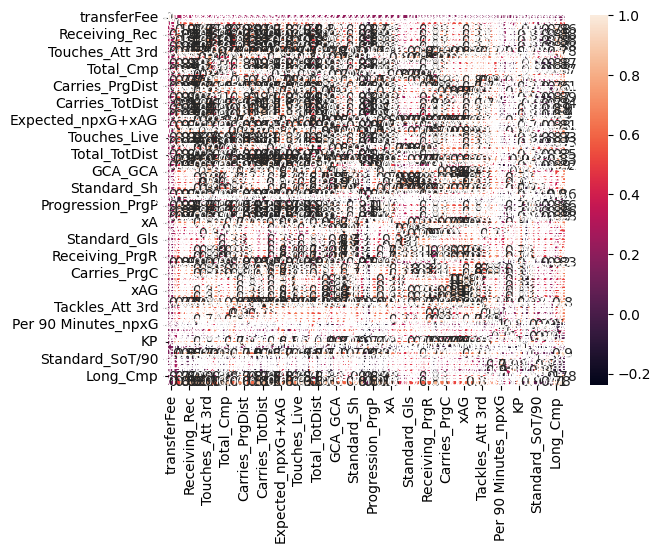

In [ ]:
df = mid_stats[type]
model_df = df.copy()
df = removeExtraCols(df)
getBestCols(df)


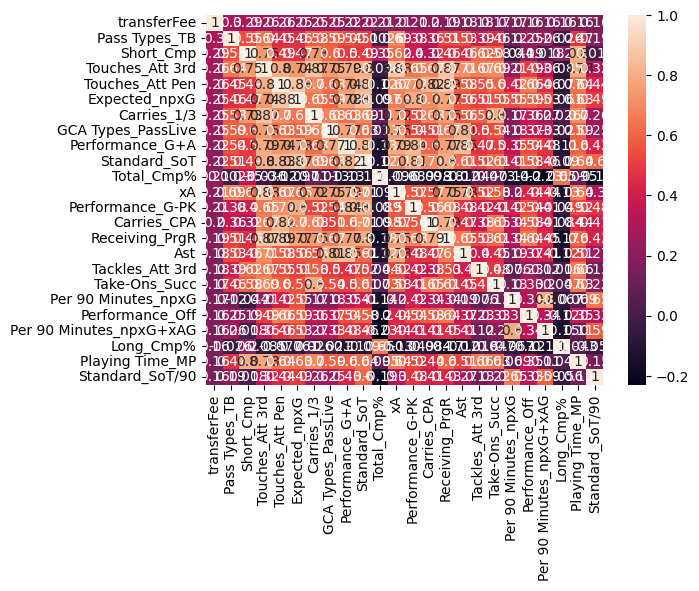

In [ ]:
corr_matrix = removedAutocorrelations(df)


In [ ]:
column_correlations = corr_matrix['transferFee']

# Calcular os valores absolutos das correlações
abs_correlations = column_correlations.abs()

# Ordenar os valores absolutos em ordem decrescente
sorted_correlations = abs_correlations.sort_values(ascending=False)

# Obter as maiores correlações
top_correlations = sorted_correlations



In [ ]:
top_corr = list(top_correlations.index)
columns = model_df.columns.intersection(detailed_transfers_mod.columns)
columns = list(columns)
filtered = filter(lambda i: not i.startswith('playerPos'), columns)
filtered = list(filtered)
selected_cols = list(np.concatenate((filtered, top_corr)))
selected_cols.remove('transferFee')
selected_cols.remove('transferFee')
df = model_df
df = df.dropna()
X = df[selected_cols]  # Features
y = df['transferFee']  # Alvo


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)


y_pred = model.predict(X_test_scaled)

mse = r2_score(y_test, y_pred)
print('Coeficiente de correlação:', mse)



Coeficiente de correlação: 0.02924712441375843


## Defensors


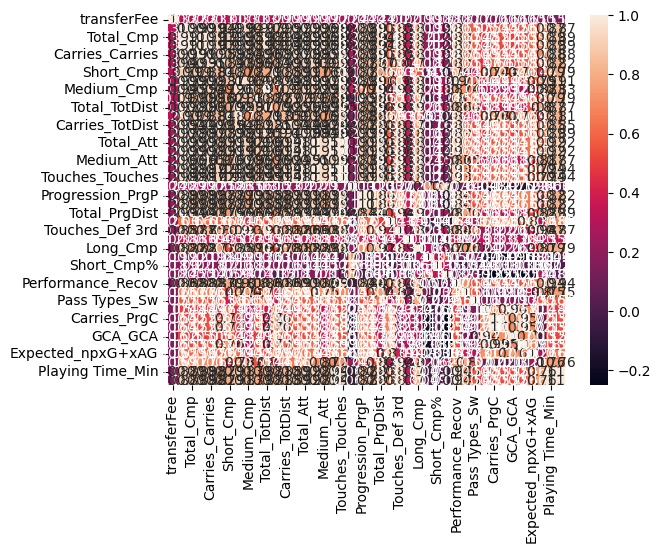

In [ ]:
df = def_stats[type]
model_df = df
df = removeExtraCols(df)
getBestCols(df)


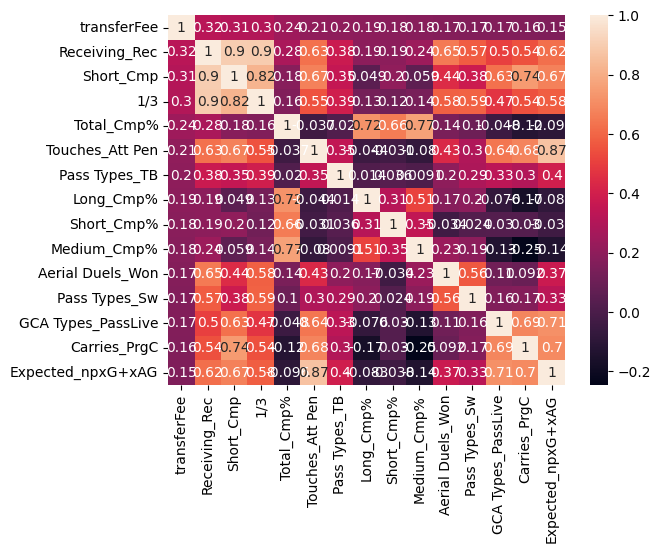

In [ ]:
corr_matrix = removedAutocorrelations(df)


In [ ]:
column_correlations = corr_matrix['transferFee']

# Calcular os valores absolutos das correlações
abs_correlations = column_correlations.abs()

# Ordenar os valores absolutos em ordem decrescente
sorted_correlations = abs_correlations.sort_values(ascending=False)

# Obter as maiores correlações
top_correlations = sorted_correlations

print(top_correlations)

transferFee           1.000000
Receiving_Rec         0.323136
Short_Cmp             0.305573
1/3                   0.299823
Total_Cmp%            0.243523
Touches_Att Pen       0.206429
Pass Types_TB         0.197403
Long_Cmp%             0.192728
Short_Cmp%            0.183121
Medium_Cmp%           0.179669
Aerial Duels_Won      0.172244
Pass Types_Sw         0.167132
GCA Types_PassLive    0.165069
Carries_PrgC          0.162969
Expected_npxG+xAG     0.154651
Name: transferFee, dtype: float64


In [ ]:
top_corr = list(top_correlations.index)
columns = model_df.columns.intersection(detailed_transfers_mod.columns)
columns = list(columns)
filtered = filter(lambda i: not i.startswith('playerPos'), columns)
filtered = list(filtered)
selected_cols = list(np.concatenate((filtered, top_corr)))
selected_cols.remove('transferFee')
selected_cols.remove('transferFee')
df = model_df
df = df.dropna()
X = df[selected_cols]  # Features
y = df['transferFee']  # Alvo


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)


y_pred = model.predict(X_test_scaled)

mse = r2_score(y_test, y_pred)
print('Coeficiente de correlação:', mse)



Coeficiente de correlação: 0.23747527705981597
